# Neural Network on the Diabetes Dataset


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Activation Functions


In [37]:
def relu(x):
    result = np.maximum(0, x)
    return result

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

## Neural Network Class


In [38]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            self.z_values.append(z)
            if i < len(self.weights) - 2:
                a = relu(z)
                self.activations.append(a)
            else:
                a = sigmoid(z)
                self.activations.append(a)
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        self.z_values.append(z)
        self.activations.append(sigmoid(z))
        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        loss = -np.mean(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))
        return loss

    def compute_accuracy(self, y_true, y_pred):
        predictions = (y_pred >= 0.5).astype(int)
        correct_predictions = np.sum(predictions == y_true)
        accuracy = correct_predictions / y_true.shape[0]
        return accuracy

    def backward(self, X, y, outputs):
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = outputs - y
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[i + 1].T
            dZ = dA * relu_derivative(self.z_values[i])
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]

    def predict_proba(self, X):
        outputs = self.forward(X)
        return outputs

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[indices[i:i + batch_size]]
                y_batch = y[indices[i:i + batch_size]]
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_accuracy = self.compute_accuracy(y, self.predict_proba(X))
            val_outputs = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_outputs)
            val_accuracy = self.compute_accuracy(y_val, self.predict_proba(X_val))
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        outputs = self.forward(X)
        predictions = (outputs >= 0.5).astype(int)
        return predictions

## Data Loading and Preparation


In [39]:
data = pd.read_csv('diabetes.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
if y.ndim == 1:
    y = y.reshape(-1, 1)
# Standardisation
X = (X - X.mean(axis=0)) / X.std(axis=0)
# Split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

## Model Training


In [40]:
layer_sizes = [X_train.shape[1], 16, 8, 1]
nn = NeuralNetwork(layer_sizes, learning_rate=0.01)
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train, y_train, X_val, y_val, epochs=100, batch_size=32
)

Epoch 0, Train Loss: 0.7156, Val Loss: 0.6592, Train Acc: 0.6522, Val Acc: 0.6429
Epoch 10, Train Loss: 0.6708, Val Loss: 0.6251, Train Acc: 0.6500, Val Acc: 0.6494
Epoch 20, Train Loss: 0.6468, Val Loss: 0.5989, Train Acc: 0.6696, Val Acc: 0.6623
Epoch 30, Train Loss: 0.6271, Val Loss: 0.5744, Train Acc: 0.6870, Val Acc: 0.6883
Epoch 40, Train Loss: 0.6106, Val Loss: 0.5517, Train Acc: 0.7109, Val Acc: 0.7208
Epoch 50, Train Loss: 0.5793, Val Loss: 0.5313, Train Acc: 0.7196, Val Acc: 0.7468
Epoch 60, Train Loss: 0.5630, Val Loss: 0.5135, Train Acc: 0.7370, Val Acc: 0.7597
Epoch 70, Train Loss: 0.5502, Val Loss: 0.4979, Train Acc: 0.7457, Val Acc: 0.7532
Epoch 80, Train Loss: 0.5353, Val Loss: 0.4853, Train Acc: 0.7587, Val Acc: 0.7662
Epoch 90, Train Loss: 0.5239, Val Loss: 0.4757, Train Acc: 0.7630, Val Acc: 0.7727


## Predictions and Evaluation



Rapport de classification (Test set) :
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154



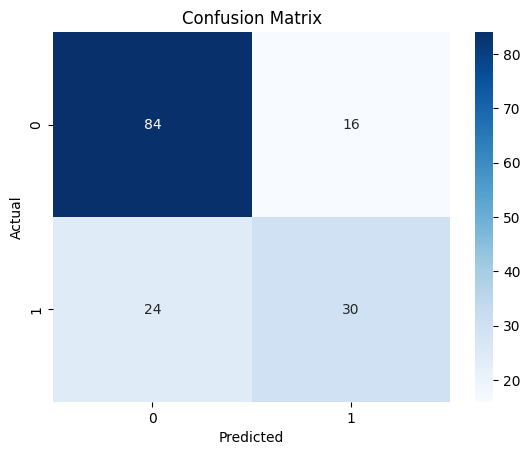

In [41]:
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Loss and Accuracy Curves


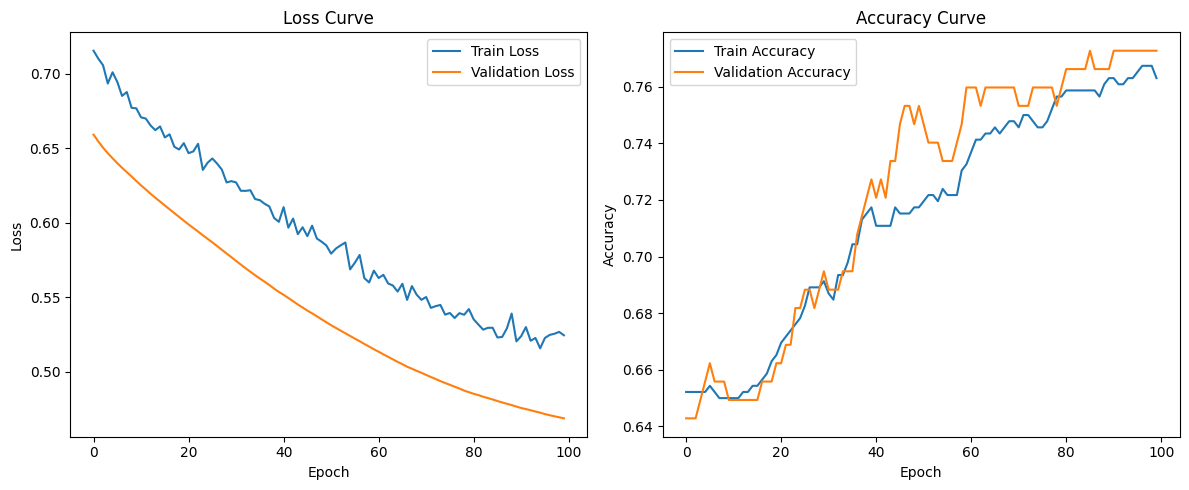

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()